In [36]:
using KFactors, Pipe, DataFrames, StatsBase, Statistics, Dates, Plots, CSV, GLM, CategoricalArrays, RegressionTables, StatsPlots, DataFramesMeta

In [2]:
full_data = read_data("../data/peaks_merged.parquet")
all_sensors = KFactors.create_test_data(full_data, KFactors.Periods.SPRING_2022, min_complete=0);

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.90%)
└ @ KFactors /Users/mwbc/git/peak-spreading/src/computation.jl:65


In [3]:
stdata = @pipe groupby(full_data, :station) |> combine(_,
    :periods_imputed => (x -> sum(288 .- x)) => :periods_observed,
    :date => minimum => :first_seen,
    :date => maximum => :last_seen
);

In [4]:
mean((1, 2))

1.5

## Inverted U pattern

In robustness tests, we observed that using all sensors, or setting a higher cutoff for imputation, resulted in larger in magnitude changes. Here we plot the cutoff against the estimated change in peak hour occupancy proportion.

In [5]:
time_to_secs(x) = hour(x) * 3600 + minute(x) * 60 + second(x)
secs_to_time(x) = Time(x ÷ 3600, (x % 3600) ÷ 60, x % 60)

station_stats = @pipe groupby(all_sensors, [:station, :period]) |>
    combine(_,
        :peak_hour_occ => mean,
        :hours_of_congestion => mean,
        :peak_hour_start => (x -> secs_to_time(median(time_to_secs.(x)))) => :peak_hour_start_median,
        :total_flow => mean,
        :periods_imputed => (x -> mean(x) / 288) => :percent_imputed
    )

station_stats = leftjoin(
    station_stats[station_stats.period .== :prepandemic, :],
    station_stats[station_stats.period .== :postlockdown, :],
    renamecols=:_prepandemic=>:_postlockdown,
    on=:station
    )

station_stats.Δocc_mean = station_stats.peak_hour_occ_mean_postlockdown .- station_stats.peak_hour_occ_mean_prepandemic;


In [6]:
xs = 0:0.01:1
ys = map(xs) do x
    sts = Set(station_stats[station_stats.percent_imputed_prepandemic .≤ x .&& station_stats.percent_imputed_postlockdown .≤ x, :station])
    val = mean(all_sensors[all_sensors.station .∈ Ref(sts) .&& all_sensors.period .== :postlockdown, :peak_hour_occ]) -
        mean(all_sensors[all_sensors.station .∈ Ref(sts) .&& all_sensors.period .== :prepandemic, :peak_hour_occ])
    
    length(sts), val
end;
n_sensors = [y[1] for y in ys]
est = [y[2] for y in ys];

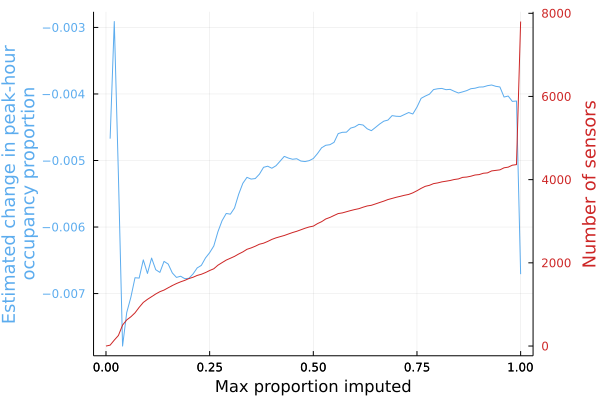

In [7]:
plot(xs, est, xlabel="Max proportion imputed", ylabel="Estimated change in peak-hour\noccupancy proportion", legend=false, right_margin=15Plots.mm,
    yguidefont=font(:steelblue2, pointsize=12), ytickfont=font(:steelblue2, pointsize=8), color=:steelblue2)
plot(twinx(), xs, n_sensors, ylabel="Number of sensors", legend=false,
    yguidefont=font(:firebrick3, pointsize=12), ytickfont=font(:firebrick3, pointsize=8), color=:firebrick3)

## Reasons for inverted U

I'm guessing it has to do with imputation methods. Sensors that never reported valid data are imputed differently. Unfortunately, Caltrans does not provide information on what imputation method was used for each data point, though they do have this data within PeMS. As a cross-check, though, perform some regressions of other possible causes.

In [8]:
meta = CSV.read("../data/sensor_meta_geo.csv", DataFrame)
leftjoin!(station_stats, meta, on=:station=>:ID);

In [9]:
station_stats.fully_imputed = station_stats.percent_imputed_prepandemic .== 1 .|| station_stats.percent_imputed_postlockdown .== 1
station_stats.sflow_per_lane = standardize(ZScoreTransform, station_stats.total_flow_mean_prepandemic ./ convert.(Int64, station_stats.Lanes) ./ 1000)
station_stats.am_peak = station_stats.peak_hour_start_median_prepandemic .< Time(12)
station_stats.District = CategoricalArray(station_stats.District)
station_stats.max_percent_imputed = max.(station_stats.percent_imputed_prepandemic, station_stats.percent_imputed_postlockdown);

In [10]:
fullmod = glm(@formula(fully_imputed~urban+sflow_per_lane+District+am_peak+hours_of_congestion_mean_prepandemic), station_stats, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

fully_imputed ~ 1 + urban + sflow_per_lane + District + am_peak + hours_of_congestion_mean_prepandemic

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────
                                            Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                            0.00182614   0.132459    0.01    0.9890  -0.257789    0.261442
urban                                 -0.320575     0.0698491  -4.59    <1e-05  -0.457476   -0.183673
sflow_per_lane                         0.14648      0.0321276   4.56    <1e-05   0.083511    0.209449
District: 4                            0.534935     0.

In [11]:
mod = lm(@formula(max_percent_imputed~urban+sflow_per_lane+District+am_peak+hours_of_congestion_mean_prepandemic), station_stats[.!station_stats.fully_imputed, :])

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

max_percent_imputed ~ 1 + urban + sflow_per_lane + District + am_peak + hours_of_congestion_mean_prepandemic

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────────
                                             Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                            0.446952     0.0234031   19.10    <1e-77   0.40107      0.492834
urban                                 -0.017263     0.0124754   -1.38    0.1665  -0.041721     0.00719509
sflow_per_lane                         0.00407873   0.00559565   0.73    0.4661  -0.00689158   0.0150491
District: 4                           -0.104629     0.0224689   -

In [12]:
occmod = lm(@formula(Δocc_mean~urban+sflow_per_lane+District+am_peak+hours_of_congestion_mean_prepandemic), station_stats)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Δocc_mean ~ 1 + urban + sflow_per_lane + District + am_peak + hours_of_congestion_mean_prepandemic

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                             Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                           -0.00795618   0.00125407   -6.34    <1e-09  -0.0104145    -0.00549787
urban                                 -0.00287279   0.000637826  -4.50    <1e-05  -0.0041231    -0.00162248
sflow_per_lane                         0.00426829   0.00028898   14.77    <1e-47   0.00370181    0.00483476
District: 4                            0.0068785    0.001

In [13]:
regtable(fullmod, mod, occmod)


--------------------------------------------------------------------------------------
                                       fully_imputed   max_percent_imputed   Δocc_mean
                                       -------------   -------------------   ---------
                                                 (1)                   (2)         (3)
--------------------------------------------------------------------------------------
(Intercept)                                    0.002              0.447***   -0.008***
                                             (0.132)               (0.023)     (0.001)
urban                                      -0.321***                -0.017   -0.003***
                                             (0.070)               (0.012)     (0.001)
sflow_per_lane                              0.146***                 0.004    0.004***
                                             (0.032)               (0.006)     (0.000)
District: 4                               

There don't appear to be a lot of other factors that could explain the differences. For a variable to cause the inverted U shape, it would have to have a significant positive (negative) relationship with occ_mean, and significant negative (positive) relationship with fully-imputed, and significant positive (negative) relationship with max_percent_imputed.

The only variables I see that meet that criterion is D4. Of course, the district columns are hard to interpret since they're dummy coded.

In [14]:
@pipe groupby(station_stats, :District) |> combine(_,
    :max_percent_imputed => mean,
    :fully_imputed => mean
)

,District,max_percent_imputed_mean,fully_imputed_mean
,Cat…?,Float64,Float64
1,3,0.651341,0.385382
2,4,0.665452,0.503109
3,5,0.481345,0.185304
4,6,0.367805,0.155914
5,7,0.812768,0.63346
6,8,0.714782,0.501139
7,10,0.622964,0.312937
8,11,0.437508,0.238901
9,12,0.514128,0.250524


### what percentage of sensors are from each district at each cutoff point?

In [15]:
xs = 0:0.01:1
ys = zeros(Float64, length(xs), 12)

for (cix, cutoff) in enumerate(xs)
    ds = station_stats[station_stats.percent_imputed_prepandemic .≤ cutoff .&& station_stats.percent_imputed_postlockdown .≤ cutoff, :District]
    for district in 1:12
        ys[cix, district] = mean(ds .== district)
    end
end

In [22]:
order = [3 12 11 4 7 6 10 8 5]
areaplot(xs, dropdims(ys[:,order], dims=2), labels=order, legend=:outertopright)

LoadError: cannot assign a value to variable DataFrames.order from module Main

In [23]:
ENV["COLUMNS"] = 120

composition = DataFrame(round.(ys[6:10:end,:], digits=2), "District " .* string.(1:12))
composition.cutoff = xs[6:10:end]
select!(composition, ["cutoff", "District 3", "District 4", "District 5", "District 6", "District 7", "District 8", "District 10", "District 11", "District 12"])
composition

,cutoff,District 3,District 4,District 5,District 6,District 7,District 8,District 10,District 11,District 12
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.05,-0.02,-0.01,0.02,-0.0,-0.01,-0.01,0.0,-0.01,-0.0
2,0.15,-0.02,-0.01,-0.0,-0.0,-0.0,-0.0,0.0,-0.01,-0.01
3,0.25,-0.02,-0.01,-0.0,-0.0,-0.0,-0.0,0.0,-0.01,-0.01
4,0.35,-0.01,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.01,-0.01
5,0.45,-0.01,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.01,-0.01
6,0.55,-0.01,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.01,-0.01
7,0.65,-0.01,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.01,-0.01
8,0.75,-0.01,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.01,-0.01
9,0.85,-0.01,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.01,-0.01


Los Angeles (D7) and the Bay Area (D4) are overrepresented among fully imputed sensors. More imputed sensors probably generally leads to smaller magnitude estimates because they may be imputed based on prepandemic data. Overrepresentation of some districts and different imputation methods may explain the course reversal when fully imputed stations are included.

## Do we see the same pattern among all districts?

i.e. is the inverted-U resulting from district mix?

In [24]:
xs = 0:0.01:1
ys = zeros(Float64, length(xs), 12)

for (cidx, cutoff) in enumerate(xs)
    for district in 3:12
        sts = Set(station_stats[station_stats.percent_imputed_prepandemic .≤ cutoff .&&
                station_stats.percent_imputed_postlockdown .≤ cutoff .&&
                station_stats.District .== district, :station])
        ys[cidx, district] = mean(all_sensors[all_sensors.station .∈ Ref(sts) .&& all_sensors.period .== :postlockdown, :peak_hour_occ]) -
            mean(all_sensors[all_sensors.station .∈ Ref(sts) .&& all_sensors.period .== :prepandemic, :peak_hour_occ])
    end
end

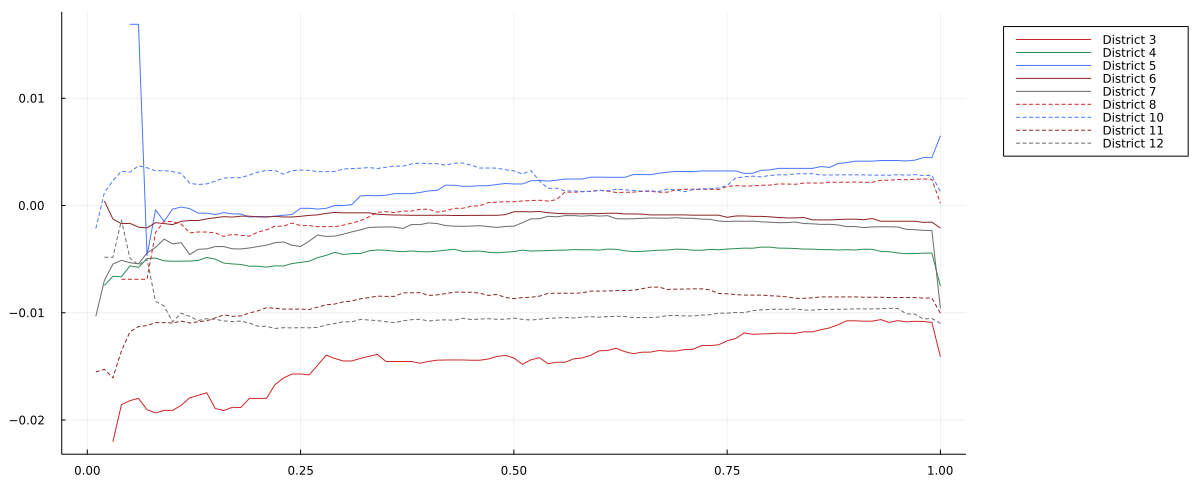

In [25]:
plot(legend=:outertopright, size=(1200, 480))
colors = [:firebrick3 :seagreen :royalblue1 :brown4 :gray42]
styles = [:solid :dash]
for district in 3:12
    district == 9 || plot!(xs, ys[:,district], label="District $district",
        color=colors[(district - 3) % length(colors) + 1], linestyle=district >= 8 ? :dash : :solid)
end
plot!()

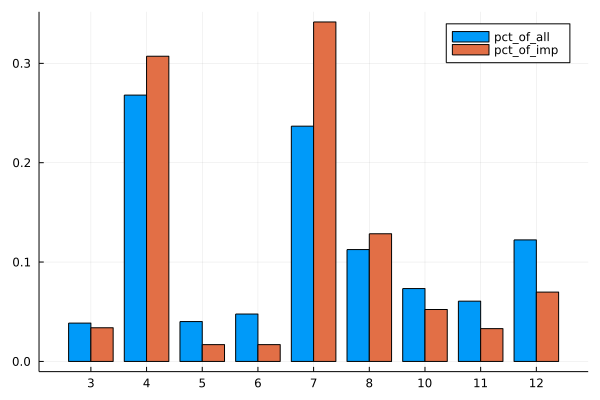

In [37]:
df1 = @pipe groupby(station_stats[station_stats.fully_imputed, :], :District) |>
        combine(_, :fully_imputed => (x -> length(x) / sum(station_stats.fully_imputed)) => :pct_of_imp)
df2 = @pipe groupby(station_stats, :District) |>
        combine(_, :fully_imputed => (x -> length(x) / nrow(station_stats)) => :pct_of_all)
fully_imputed_by_district = @pipe leftjoin(df1, df2, on=:District) |>
    stack(_, Not(:District))
@with fully_imputed_by_district groupedbar(:District, :value, group=:variable)

It appears to not only be a district mix effect, but also an imputation effect - drop at cutoff 1 is common in most districts. That said, Districts 4 and 7 are overrepresented.

## Is it an urban area effect?

In [68]:
xs = 0:0.01:1
ys = zeros(Float64, length(xs), 2)

for (cidx, cutoff) in enumerate(xs)
    for urban in [true, false]
        sts = Set(station_stats[station_stats.percent_imputed_prepandemic .≤ cutoff .&&
                station_stats.percent_imputed_postlockdown .≤ cutoff .&&
                station_stats.urban .== urban, :station])
        ys[cidx, urban ? 2 : 1] = mean(all_sensors[all_sensors.station .∈ Ref(sts) .&& all_sensors.period .== :postlockdown, :peak_hour_occ]) -
            mean(all_sensors[all_sensors.station .∈ Ref(sts) .&& all_sensors.period .== :prepandemic, :peak_hour_occ])
    end
end

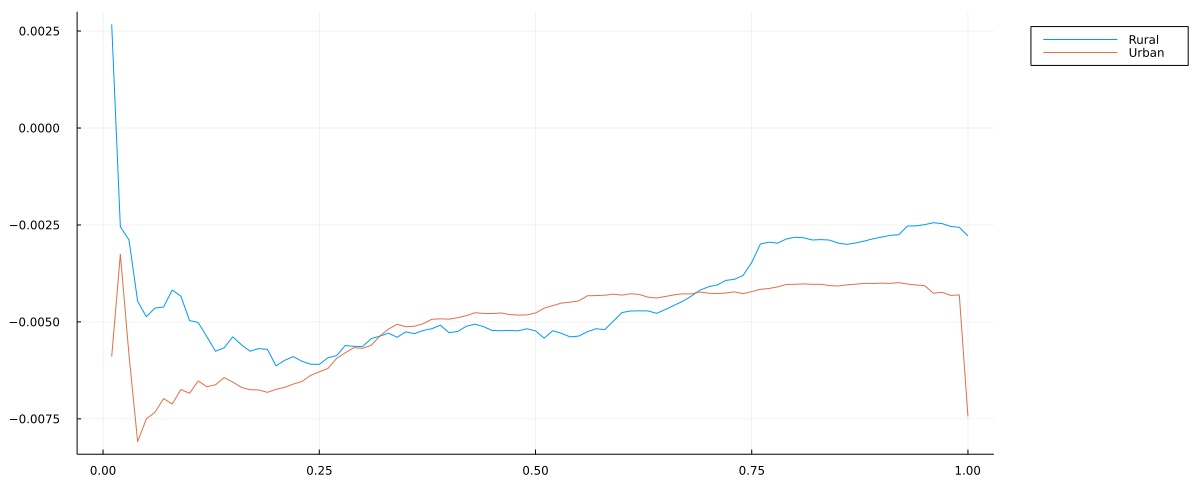

In [69]:
plot(legend=:outertopright, size=(1200, 480))
colors = [:firebrick3 :seagreen :royalblue1 :brown4 :gray42]
styles = [:solid :dash]
plot!(xs, ys[:,1], label="Rural")
plot!(xs, ys[:,2], label="Urban")

Drop at cutoff 1 only apparent in urban areas. Are urban areas overrepresented in fully imputed? Not really. But there's just a lot of urban sensors overall so an urban-only drop washes out whatever is happening in rural areas.

In [70]:
@pipe groupby(station_stats, :fully_imputed) |> combine(_, :urban => mean)

,fully_imputed,urban_mean
,Bool,Float64
1,0,0.809186
2,1,0.822482


In [38]:
@pipe groupby(station_stats, :District) |> combine(_, :urban => mean)

,District,urban_mean
,Cat…?,Float64
1,3,0.744186
2,4,0.830225
3,5,0.776358
4,6,0.52957
5,7,0.968598
6,8,0.747153
7,10,0.484266
8,11,0.906977
9,12,0.845912
